# Synthetic data test to analyse the robustness agains non-spherical sources

This notebook generates the results and figures for section "Robustness against non-spherical sources".

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries and define some functions needed for error propagation.

In [1]:
%matplotlib inline
import numpy
import scipy
from scipy import sparse
from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, prism, polyprism, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, contaminate, gaussian2d
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir
import fatiando

In [2]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [4]:
mpl.rcParams['font.size'] = 14

In [5]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = numpy.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = numpy.sqrt(numpy.diagonal((uncertainty_data**2)*H.dot(H.T)))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

def uncertainty_L2(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L2 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    dp = numpy.sqrt(numpy.diagonal((uncertainty_data**2)*numpy.linalg.inv(solver.jacobian(p=None).T.dot(solver.jacobian(p=None)))))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

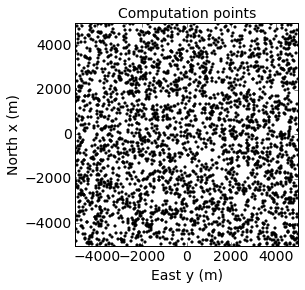

In [6]:
inc, dec = -10.0, -15.0 # inclination and declination of the Geomagnetic Field

incs = 30.0  # inclination of the magnetization vector of the prism
decs = -40.0 # declination of the magnetization vector of the prism
ints = 6.0   # intensity of the magnetization vector of the prism

# geometry of the reference prism
Lx = 1000.0
Ly = Lx
Lz = Lx

z0 = 0.01*Lz # depth of the top

Cx = 0.0
Cy = 0.0
Cz = z0 + 0.5*Lz

X1 = Cx - 0.5*Lx
X2 = Cx + 0.5*Lx
Z1 = z0
Z2 = z0 + Lz

# Center of the synthetic prism
center = [[Cx, Cy, Cz]]

# Geometry of the computation points
area = [Cx - 5*Lx, Cx + 5*Lx, Cy - 5*Ly, Cy + 5*Ly]
x, y, z = gridder.scatter(area, 3000, z=0.0, seed=0)

uncertainty_data = 5.0 # nT

mpl.close('all')
mpl.figure()
mpl.axis('scaled')
mpl.title('Computation points', fontsize = 14)
mpl.points(numpy.vstack((x, y)).T, style='.k', size=5)
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.xlim(area[2], area[3])
mpl.ylim(area[0], area[1])
mpl.show()

In [7]:
LL = 0.8*Ly # maximum amplitude of the variation in Ly
LN = 11 # number of prisms with different Ly

LD = ((2.0*LL)/(LN - 1.0)) # minimum difference between prisms with different Ly
L0 = Ly - LL # Ly of the smallest prism

ZL = -0.6*Lz # maximum distance between the top depth and the data
ZN = 3 # number of planar surfaces on with the data will be calculated (data planes)

ZD = (ZL/(ZN - 1.0)) # minimum difference between different data planes
Z0 = 0.0 # vertical coordinate of the lowest data plane

In [9]:
estimates_L1_dec = numpy.zeros((ZN, LN))
estimates_L1_inc = numpy.zeros((ZN, LN))
estimates_L2_dec = numpy.zeros((ZN, LN))
estimates_L2_inc = numpy.zeros((ZN, LN))

relative_lenght = numpy.zeros(LN)

for j in range(LN):
    L = L0 + (j*LD)
    relative_lenght[j] = (L/Lx)

In [10]:
Z = 0.0
for k in range(ZN):    
    for j in range(LN):    
        L = L0 + (j*LD)
        Y1 = Cy - 0.5*L
        Y2 = Cy + 0.5*L
        
        # Create the prism
        prism = [mesher.Prism(X1, X2, Y1, Y2, Z1, Z2, 
                               {'magnetization': ang2vec(ints, incs, decs)})]
    
        # Total field anomaly containated with Gaussian noise with zero 
        # mean and standard deviation 5.0 nT
        tf = gravmag.prism.tf(x, y, z + Z, prism, inc, dec)
        #tf = contaminate(tf, uncertainty_data, seed = 345)
    
        #L2-norm estimate
        solver_L2 = DipoleMagDir(x, y, z + Z, tf, inc, dec, center).fit()
    
        # L1-norm estimate
        solver_L1 = DipoleMagDir(x, y, z + Z, tf, inc, dec, center).fit()
        for i in range(100):
            w = numpy.abs(solver_L1.residuals())
            w[w < 10**(-10)] = 10**-10
            w = 1/w
            solver_L1.set_weights(w)
            solver_L1.fit()
    
        # Calculate the uncertainties
        dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
        dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)
        
        estimates_L1_dec[k][j] = solver_L1.estimate_[0][2]
        estimates_L1_inc[k][j] = solver_L1.estimate_[0][1]
        estimates_L2_dec[k][j] = solver_L2.estimate_[0][2]
        estimates_L2_inc[k][j] = solver_L2.estimate_[0][1]
    
    Z += ZD

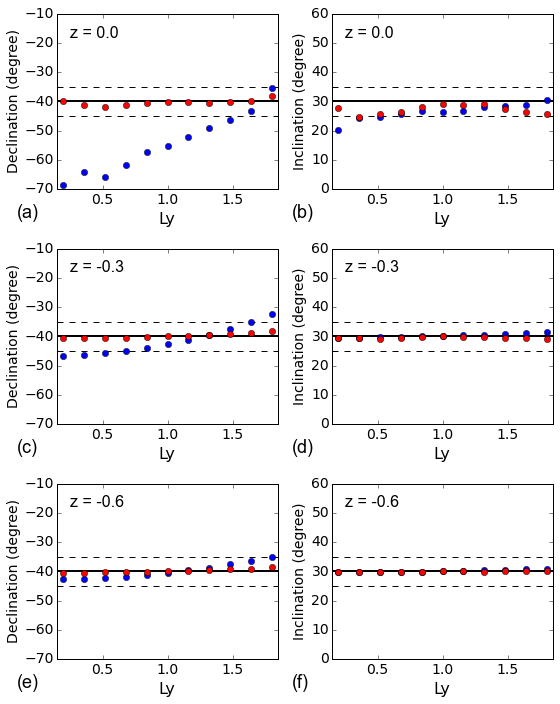

In [12]:
dsr = 0.03*(relative_lenght[-1] - relative_lenght[0])
dsd = 30.0
marker_size = 6
font_size = 10

letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

mpl.close('all')
mpl.figure(figsize = (8,10), tight_layout = True)

for k in range(ZN):
    mpl.subplot(ZN,2,2*k+1)
    mpl.paths([[relative_lenght[0] - dsr, decs]], [[relative_lenght[-1] + dsr, decs]], style='-k', linewidth=2, label='True')
    mpl.paths([[relative_lenght[0] - dsr, decs + 5]], [[relative_lenght[-1] + dsr, decs + 5]], style='--k', linewidth=1)
    mpl.paths([[relative_lenght[0] - dsr, decs - 5]], [[relative_lenght[-1] + dsr, decs - 5]], style='--k', linewidth=1)
    mpl.plot(relative_lenght, estimates_L2_dec[k], 'ob', markersize = marker_size)
    mpl.plot(relative_lenght, estimates_L1_dec[k], 'or', markersize = marker_size)
    #mpl.legend(loc='upper left', numpoints=1, fontsize=14)
    mpl.xlabel('Ly', fontsize = 16)
    mpl.ylabel('Declination (degree)', fontsize = 14)
    mpl.xlim(relative_lenght[0] - dsr,relative_lenght[-1] + dsr)
    mpl.ylim(decs - dsd, decs + dsd)
    zcoord = 'z = %.1f' % (k*(ZD/Lz) + 0.0001) 
    mpl.text(0.25, -18.0, zcoord, fontsize=16, family = 'arial')
    mpl.text(-0.15, -80, letters[2*k], fontsize=18, family = 'arial')

for k in range(ZN):
    mpl.subplot(ZN,2,2*k+2)
    mpl.paths([[relative_lenght[0] - dsr, incs]], [[relative_lenght[-1] + dsr, incs]], style='-k', linewidth=2, label='True')
    mpl.paths([[relative_lenght[0] - dsr, incs + 5]], [[relative_lenght[-1] + dsr, incs + 5]], style='--k', linewidth=1)
    mpl.paths([[relative_lenght[0] - dsr, incs - 5]], [[relative_lenght[-1] + dsr, incs - 5]], style='--k', linewidth=1)
    mpl.plot(relative_lenght, estimates_L2_inc[k], 'ob', markersize = marker_size)
    mpl.plot(relative_lenght, estimates_L1_inc[k], 'or', markersize = marker_size)
    #mpl.legend(loc='upper left', numpoints=1, fontsize=14)
    mpl.xlabel('Ly', fontsize = 16)
    mpl.ylabel('Inclination (degree)', fontsize = 14)
    mpl.xlim(relative_lenght[0] - dsr,relative_lenght[-1] + dsr)
    mpl.ylim(incs - dsd, incs + dsd)
    zcoord = 'z = %.1f' % (k*(ZD/Lz) + 0.0001) 
    mpl.text(0.25, 52.0, zcoord, fontsize=16, family = 'arial')
    mpl.text(-0.15, -10, letters[2*k + 1], fontsize=18, family = 'arial')

mpl.show()

In [13]:
Y1 = Cy - 0.5*Lx
Y2 = Cy + 0.5*Lx
    
# Create the prism
prism = [mesher.Prism(X1, X2, Y1, Y2, Z1, Z2, 
                      {'magnetization': ang2vec(ints, incs, decs)})]

# Total field anomaly containated with Gaussian noise with zero 
# mean and standard deviation 5.0 nT
tf = gravmag.prism.tf(x, y, z, prism, inc, dec)
tf = contaminate(tf, uncertainty_data, seed = 345)

#L2-norm estimate
solver_L2 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf, inc, dec, center).fit()
for i in range(100):
    w = numpy.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

# Print the estimated and true inclinations and declinations
print 'True'
print '%12.5f %12.5f' % (incs, decs)
print 'Estimated L2'
for e in solver_L2.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L2'
for dhj in dh_L2:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])
print 'Estimated L1'
for e in solver_L1.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L1'
for dhj in dh_L1:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

True
    30.00000    -40.00000
Estimated L2
    26.27979    -55.25128
Uncertainties L2
     0.00065      0.00091
Estimated L1
    27.82930    -41.08496
Uncertainties L1
     0.09222      0.03878


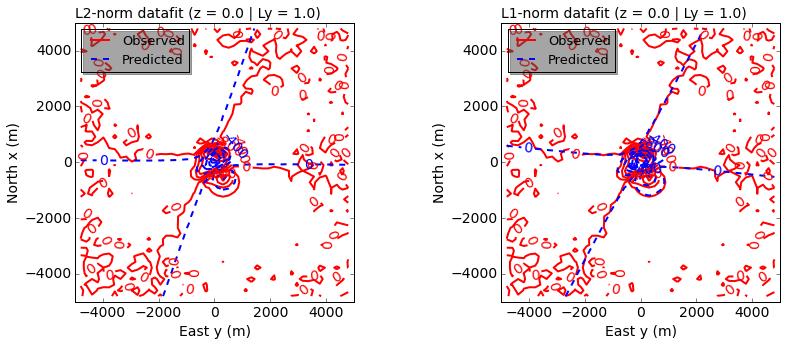

In [15]:
# Plot the observed and predicted data for the L1 and L2 estimates
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
text = "L2-norm datafit (z = %.1f | Ly = 1.0)" % Z0
mpl.title(text, fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.subplot(1, 2, 2)
text = "L1-norm datafit (z = %.1f | Ly = 1.0)" % Z0
mpl.title(text, fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.show()

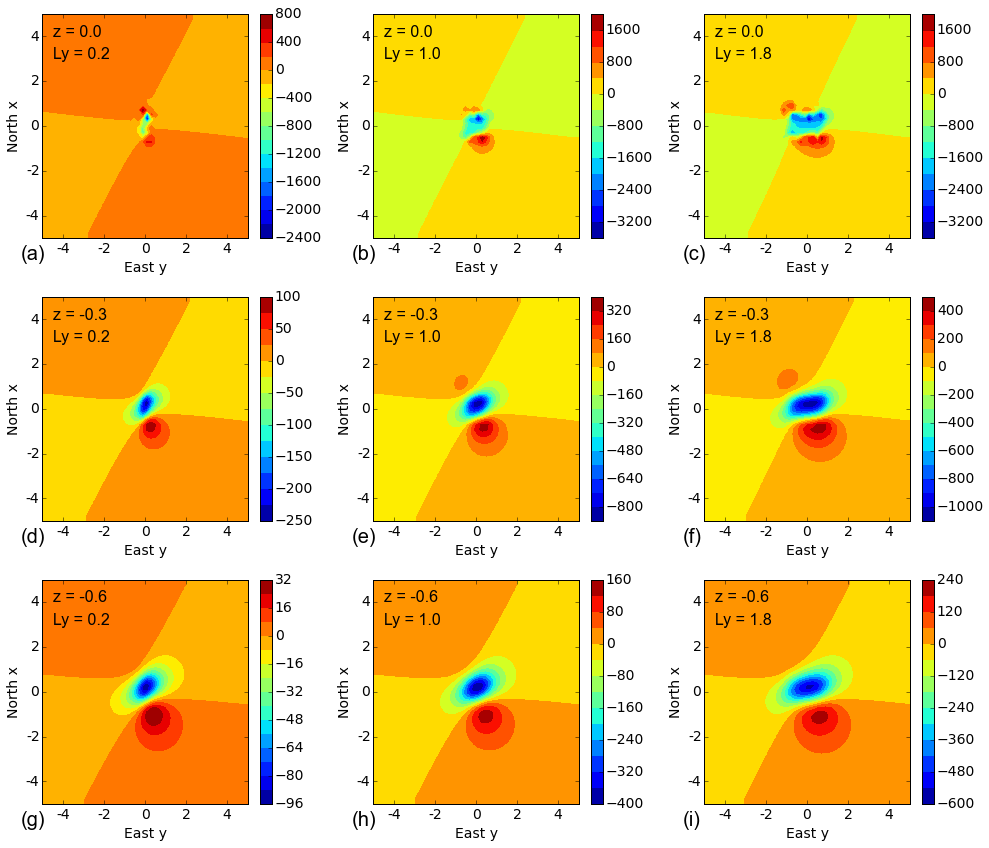

In [16]:
# Plot the data produced by different prisms at different levels z
dsxy = 1000
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
mpl.close('all')
mpl.figure(figsize = (14,12), tight_layout = True)
Z = 0.0
for k in range(ZN):
    i = (k+1)*3
    zcoord = 'z = %.1f' % (k*(ZD/Lz) + 0.0001)    
    L = L0 + 2*LL
    Y1 = Cy - 0.5*L
    Y2 = Cy + 0.5*L    
    ratio = 'Ly = %.1f' % (L/Lx)        
    # Create the prism
    prism = [mesher.Prism(X1, X2, Y1, Y2, Z1, Z2, 
                          {'magnetization': ang2vec(ints, incs, decs)})]    
    # Total field anomaly containated with Gaussian noise with zero 
    # mean and standard deviation 5.0 nT
    tf = gravmag.prism.tf(x, y, z + Z, prism, inc, dec)        
    mpl.subplot(ZN, 3, i)
    #mpl.axis('scaled')
    nlevels = mpl.contourf(y, x, tf, (50,50), 15, interp=True, extrapolate=True)
    mpl.colorbar()
    mpl.m2km()
    mpl.xlabel('East y')
    mpl.ylabel('North x')
    mpl.text(area[2] + 0.5*dsxy, area[1] - dsxy, zcoord, fontsize=16, family = 'arial')
    mpl.text(area[2] + 0.5*dsxy, area[1] - 2*dsxy, ratio, fontsize=16, family = 'arial')
    mpl.text(area[2] - dsxy, area[0] - dsxy, letters[i-1], fontsize=20, family = 'arial')
        
    i = i - 1
    
    L = L0 + LL
    Y1 = Cy - 0.5*L
    Y2 = Cy + 0.5*L
    
    ratio = 'Ly = %.1f' % (L/Lx)
        
    # Create the prism
    prism = [mesher.Prism(X1, X2, Y1, Y2, Z1, Z2, 
                          {'magnetization': ang2vec(ints, incs, decs)})]
    
    # Total field anomaly containated with Gaussian noise with zero 
    # mean and standard deviation 5.0 nT
    tf = gravmag.prism.tf(x, y, z + Z, prism, inc, dec)
        
    mpl.subplot(ZN, 3, i)
    #mpl.axis('scaled')
    mpl.contourf(y, x, tf, (50,50), 15, interp=True, extrapolate=True)
    mpl.colorbar()
    mpl.m2km()
    mpl.xlabel('East y')
    mpl.ylabel('North x')
    mpl.text(area[2] + 0.5*dsxy, area[1] - dsxy, zcoord, fontsize=16, family = 'arial')
    mpl.text(area[2] + 0.5*dsxy, area[1] - 2*dsxy, ratio, fontsize=16, family = 'arial')
    mpl.text(area[2] - dsxy, area[0] - dsxy, letters[i-1], fontsize=20, family = 'arial')
        
    i = i - 1
    
    L = L0
    Y1 = Cy - 0.5*L
    Y2 = Cy + 0.5*L
    
    ratio = 'Ly = %.1f' % (L/Lx)
        
    # Create the prism
    prism = [mesher.Prism(X1, X2, Y1, Y2, Z1, Z2, 
                          {'magnetization': ang2vec(ints, incs, decs)})]
    
    # Total field anomaly containated with Gaussian noise with zero 
    # mean and standard deviation 5.0 nT
    tf = gravmag.prism.tf(x, y, z + Z, prism, inc, dec)
        
    mpl.subplot(ZN, 3, i)
    #mpl.axis('scaled')
    mpl.contourf(y, x, tf, (50,50), 15, interp=True, extrapolate=True)
    mpl.colorbar()
    mpl.m2km()
    mpl.xlabel('East y')
    mpl.ylabel('North x')
    mpl.text(area[2] + 0.5*dsxy, area[1] - dsxy, zcoord, fontsize=16, family = 'arial')
    mpl.text(area[2] + 0.5*dsxy, area[1] - 2*dsxy, ratio, fontsize=16, family = 'arial')
    mpl.text(area[2] - dsxy, area[0] - dsxy, letters[i-1], fontsize=20, family = 'arial')
        
    i = i - 1
        
    Z += ZD

mpl.show()